In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [27]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [28]:
random_state = 0

# IMPORT DATASET

In [29]:
dataset_path = parentdir + "/datasets/PhalangesOutlinesCorrect/"

In [30]:
dataset_name = "phalanges"

In [31]:
X = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TRAIN.txt", header=None, delim_whitespace=True)
y_all = np.array(X[0]).astype("int")
#y_all[y_all == -1] = 0

X_all = X.iloc[:,1:].values
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [32]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (1800, 80, 1)
y SHAPE:  (1800,)

CLASSES BALANCE
0 :  0.35
1 :  0.65


In [33]:
X_test = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TEST.txt", header=None, delim_whitespace=True)
y_test = np.array(X_test[0]).astype("int")
#y_all[y_all == -1] = 0

X_test = X_test.iloc[:,1:].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [34]:
print("X SHAPE: ", X_test.shape)
print("y SHAPE: ", y_test.shape)

X SHAPE:  (858, 80, 1)
y SHAPE:  (858,)


## DATASET SPLIT

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (1008, 80, 1)
BLACKBOX VALIDATION SET:  (252, 80, 1)
BLACKBOX TEST SET:  (858, 80, 1)
EXPLANATION TRAINING SET:  (345, 80, 1)
EXPLANATION VALIDATION SET:  (87, 80, 1)
EXPLANATION TEST SET:  (108, 80, 1)


In [37]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  80
N. LABELS:  2


# BLACKBOX MODEL

In [38]:
"""import importlib
importlib.reload(blackboxes)"""
import keras
from sklearn.metrics import accuracy_score, mean_squared_error
from joblib import dump, load
import time
from blackboxes import *
import blackboxes

## resnet

In [39]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_resnet_20191101_164247_best_weights_+0.86_.hdf5")
resnet = blackbox

## simple CNN

In [40]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_170209_best_weights_+0.83_.hdf5")
simplecnn = blackbox

## KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [42]:
knn = load(parentdir + "/blackbox_checkpoints/phalanges_blackbox_knn_20191101_171534.joblib")

# AUTOENCODER

In [43]:
"""import importlib
importlib.reload(autoencoders)"""
import autoencoders
from autoencoders import *

## Standard

In [44]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 40,
          "encoder_latent_layer_type": "simple",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,2]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/phalanges_autoencoder_20191103_211535_best_weights_+0.0010_.hdf5")

# NEIGHBORHOOD GENERATION

In [45]:
"""import importlib
importlib.reload(agnosticlocalexplainer)"""
import agnosticlocalexplainer
from agnosticlocalexplainer import *

In [46]:
index_to_explain = 0

## RESNET

In [47]:
blackbox = resnet

In [48]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [49]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [50]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'geneticp', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	500   	0.496654	0.496654	0.496654
1  	425   	0.723802	0.496654	0.993143
2  	434   	0.960229	0.496654	0.993304
3  	441   	0.981872	0.49951 	0.993304
4  	422   	0.983617	0.499555	0.993284
5  	412   	0.985578	0.499107	0.993284
6  	418   	0.984563	0.499318	0.993284
7  	418   	0.98403 	0.499092	0.993274
8  	432   	0.981404	0.499108	0.993274
9  	412   	0.982355	0.499176	0.993264
10 	417   	0.980608	0.498791	0.993264
gen	nevals	avg	min	max
0  	500   	0.5	0.5	0.5
1  	423   	0.509821	0.498835	0.992864
2  	436   	0.522667	0.498397	0.992864
3  	419   	0.536383	0.498144	0.993088
4  	422   	0.567078	0.498256	0.992928
5  	417   	0.587516	0.4984  	0.992928
6  	410   	0.621552	0.497817	0.992998
7  	426   	0.630956	0.497585	0.992998
8  	410   	0.666268	0.498379	0.99304 
9  	433   	0.669482	0.498018	0.992998
10 	428   	0.662002	0.498362	0.992944
synthetic neighborhood class counts {0: 857, 1: 295}


In [51]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [54]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1
rule: 486 time series
crule0: 3 time series


In [55]:
agnostic.print_rules_n()

rule: 486 time series
crule0: 3 time series


In [57]:
agnostic.LOREM_rules_random_augmentation(rules_to_augment = ["crule0"], size = 6000)

calculating feature values
synthetic neighborhood class counts {0: 5674, 1: 374}
crule0 augmented by 32 random instances (45) time series total
recomputing medoids...


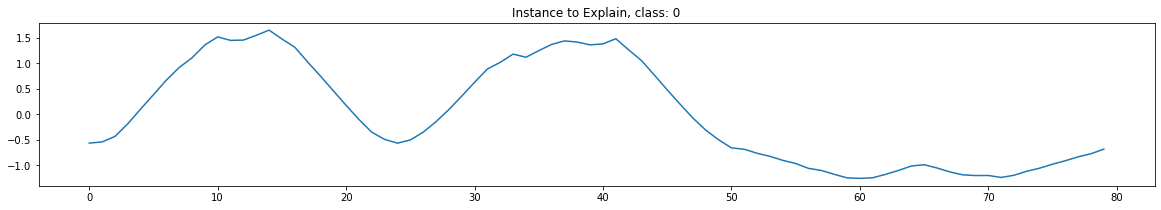

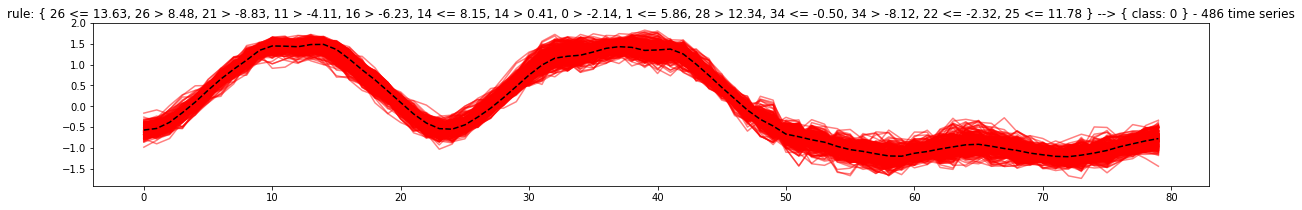

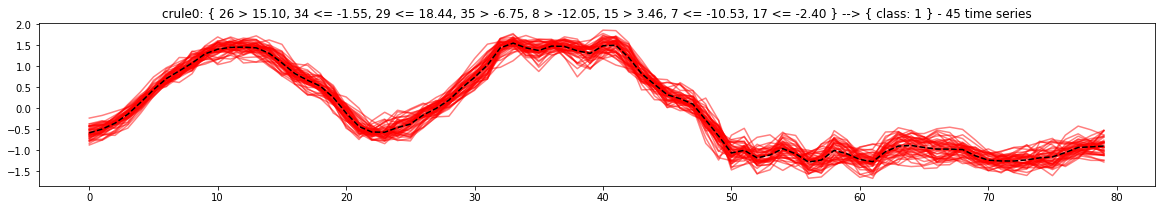

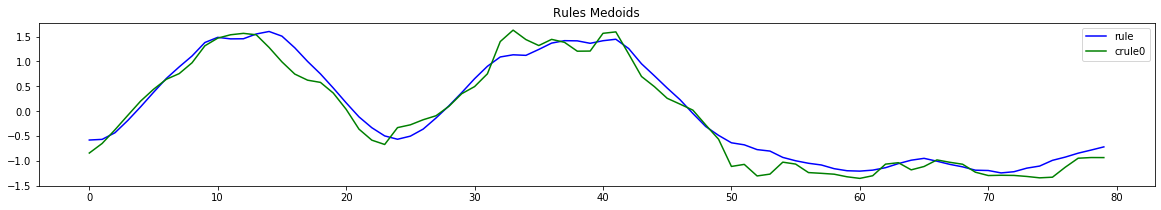

rule


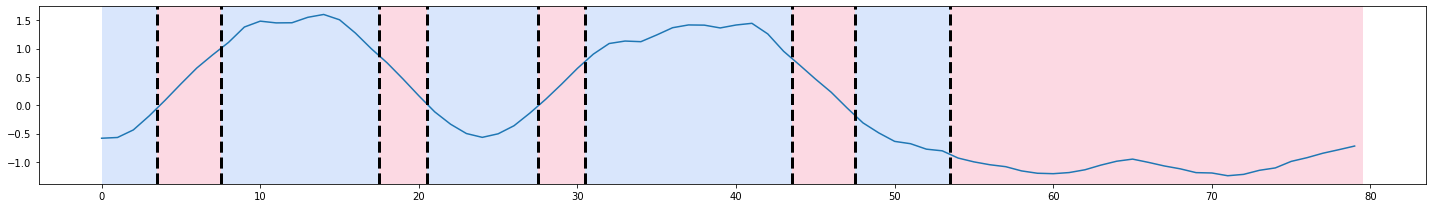

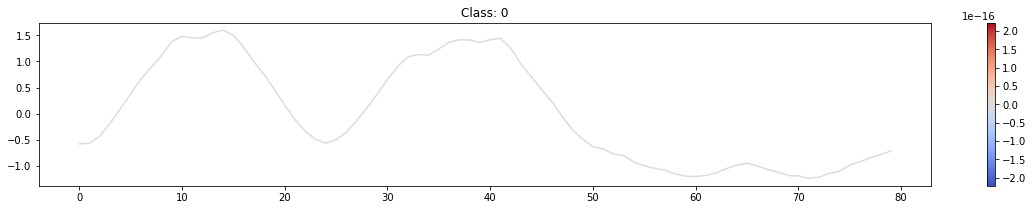

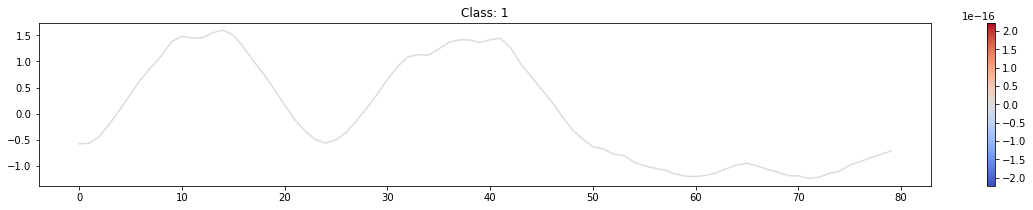

crule0


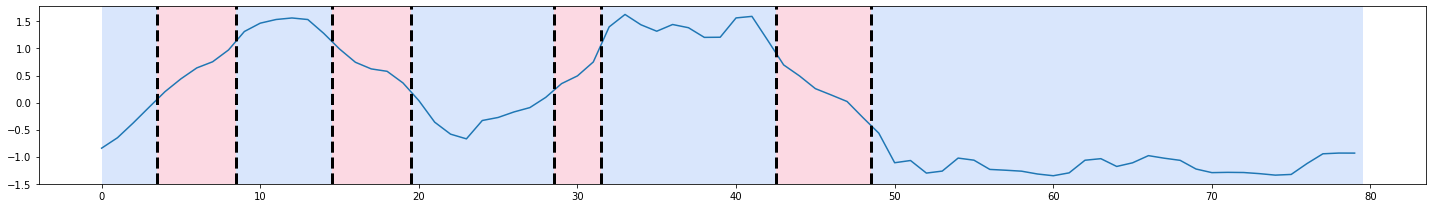

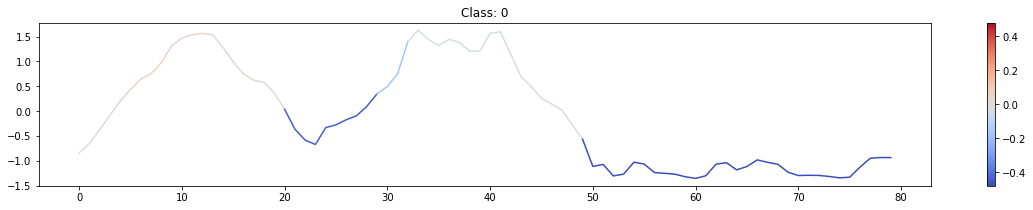

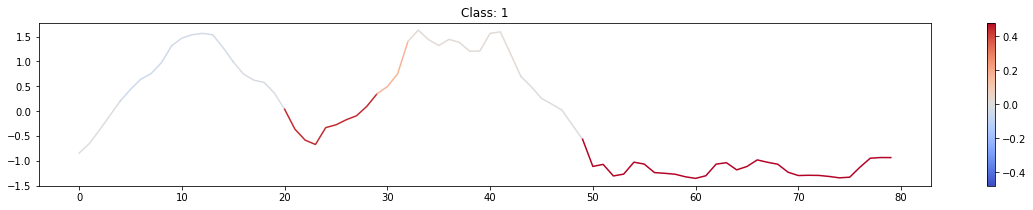

rule


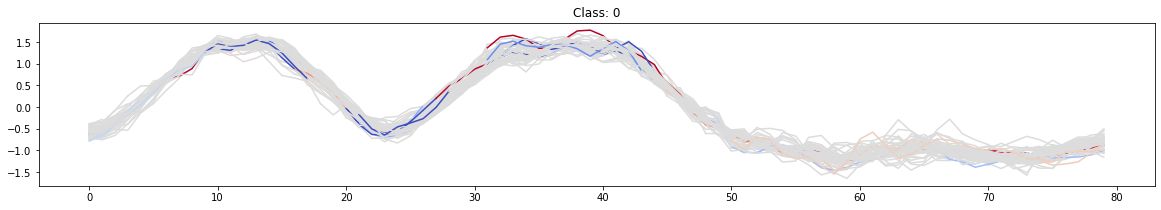

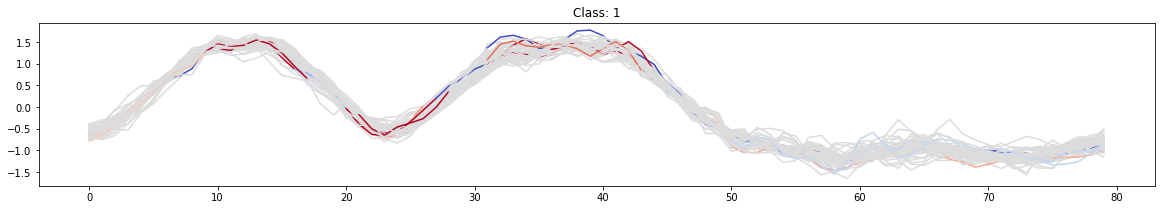

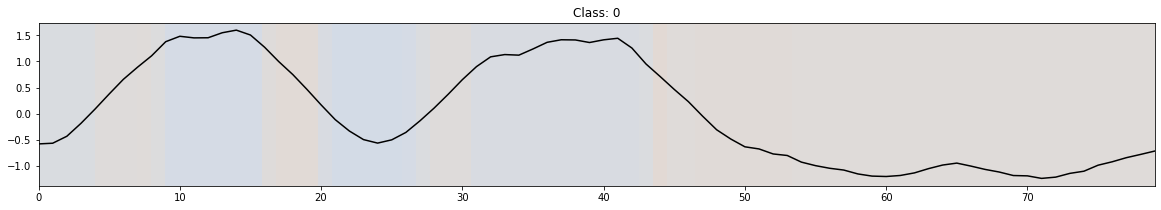

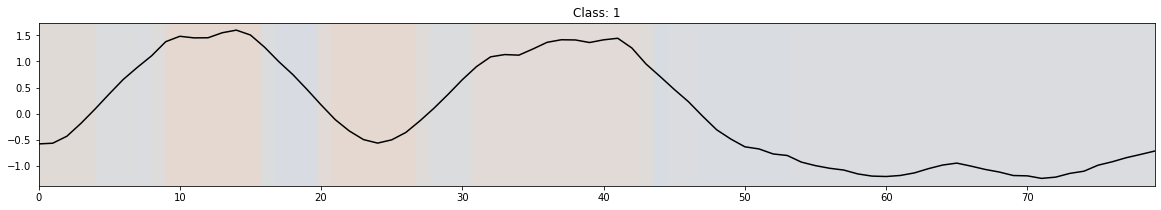

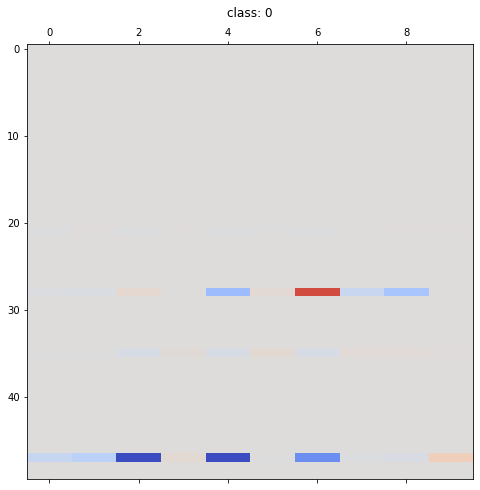

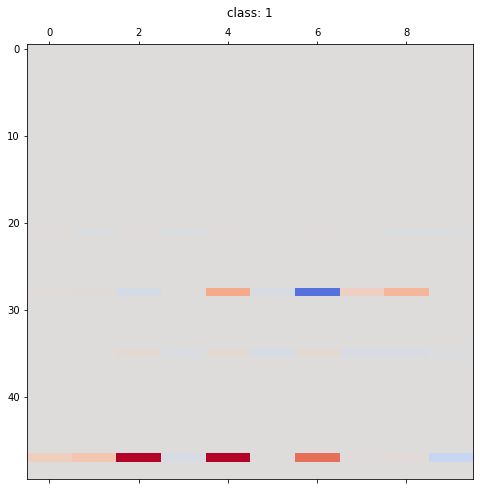

crule0


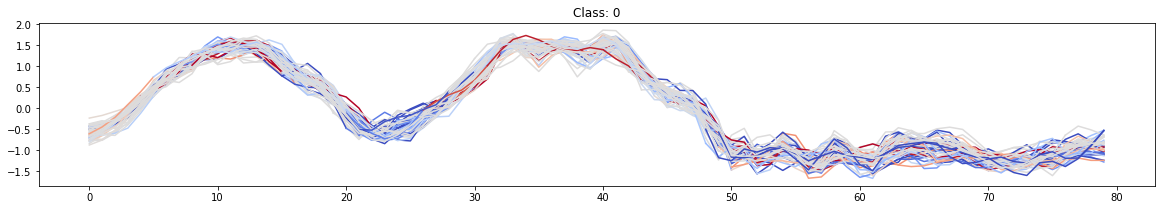

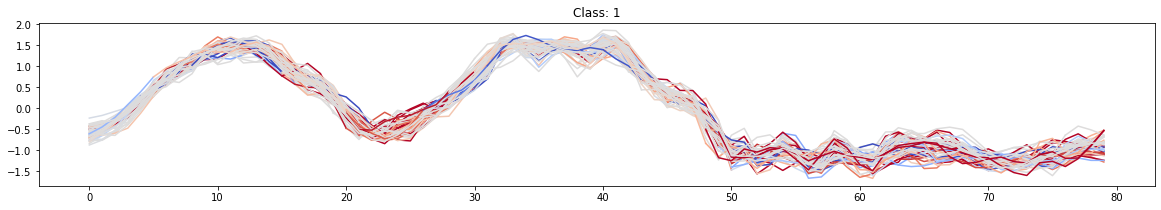

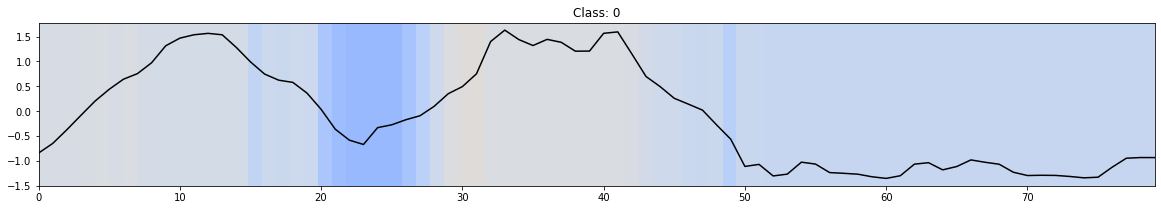

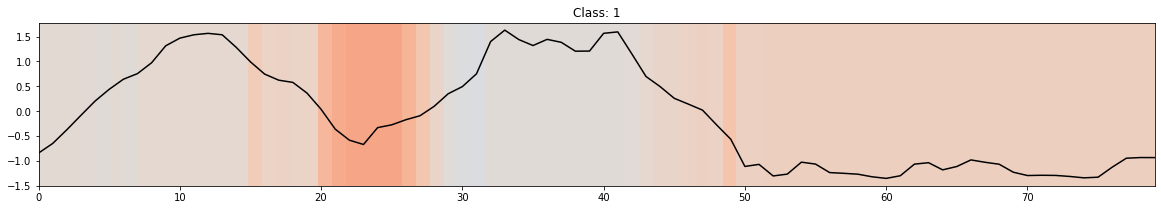

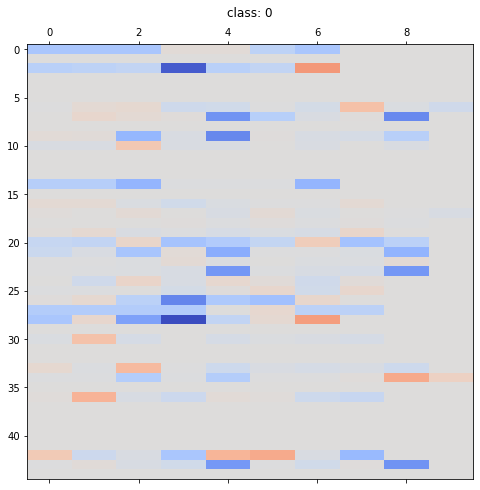

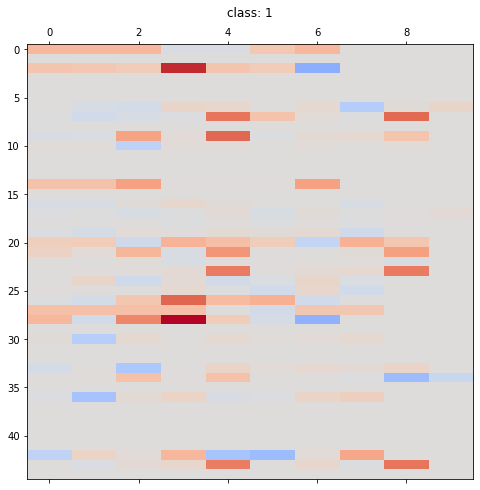

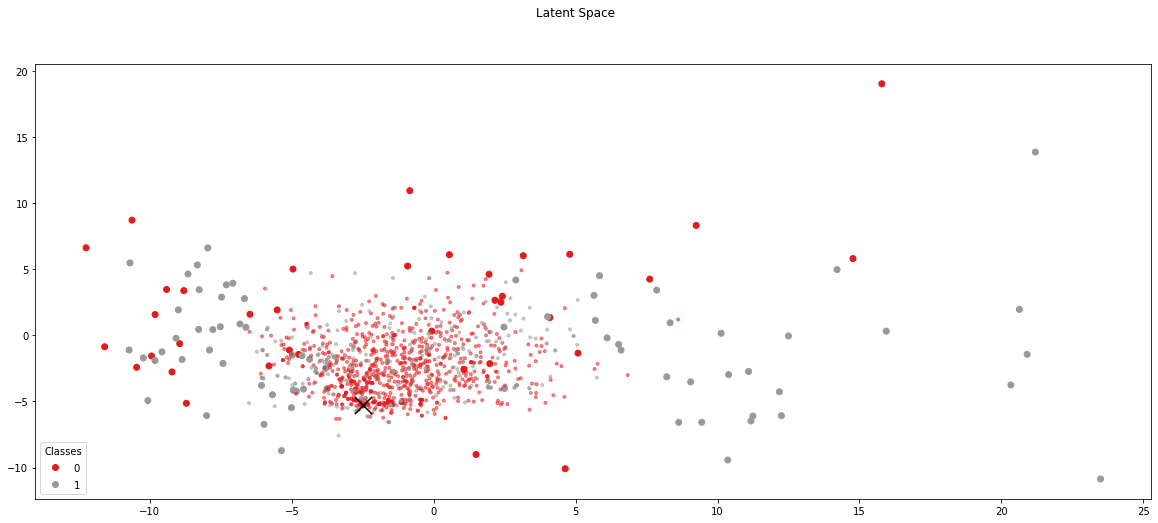

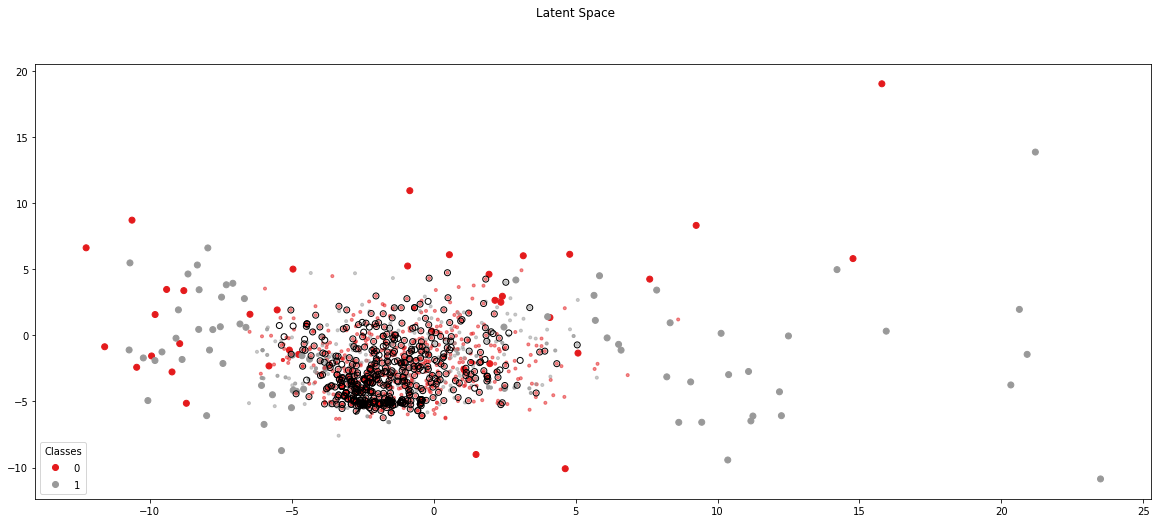

In [58]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "multishap_n":50,
          "shap_by_class" : False,
          "max_iter":50}
agnostic.plot_explanation( 
                         rules = True, 
                         heatmap = False, 
                         shap_explanation = True, 
                         shapelet_explanation = False,
                         latent_space = True,
                         multi_shap_explanation = True,
                         figsize = (20,3),
                         VAE_2d = False,
                         **params
                         )

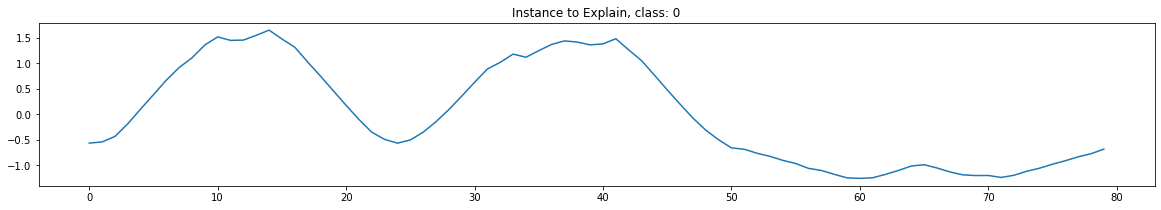

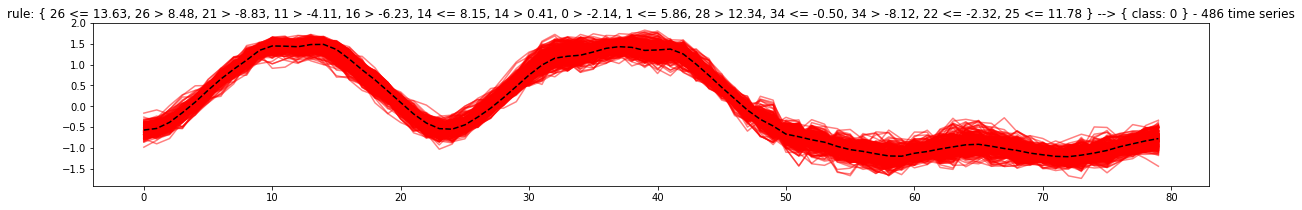

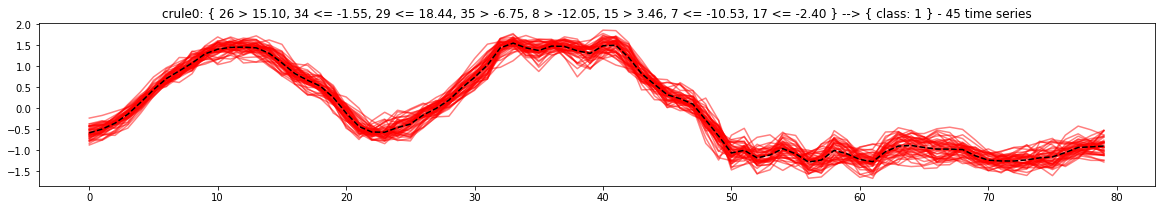

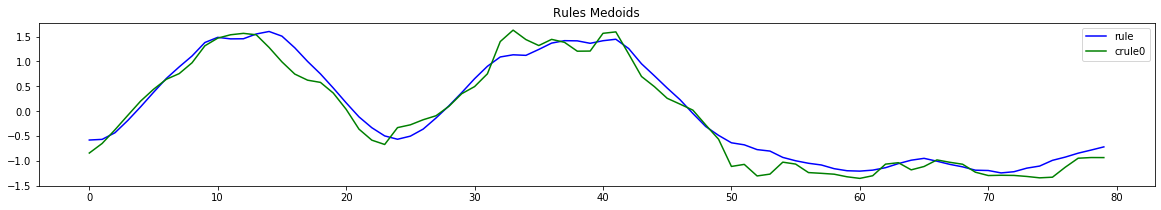

rule


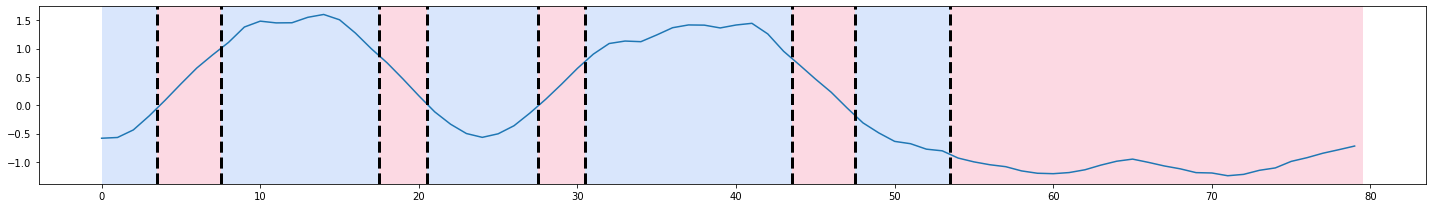

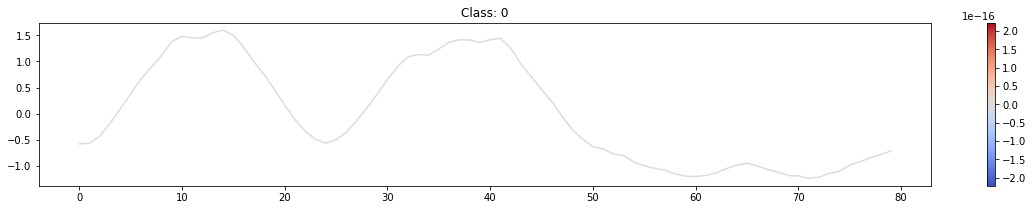

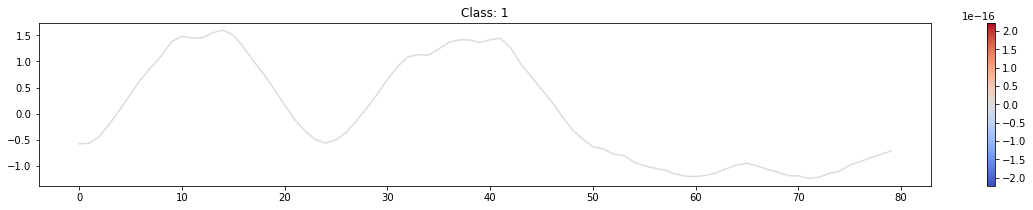

crule0


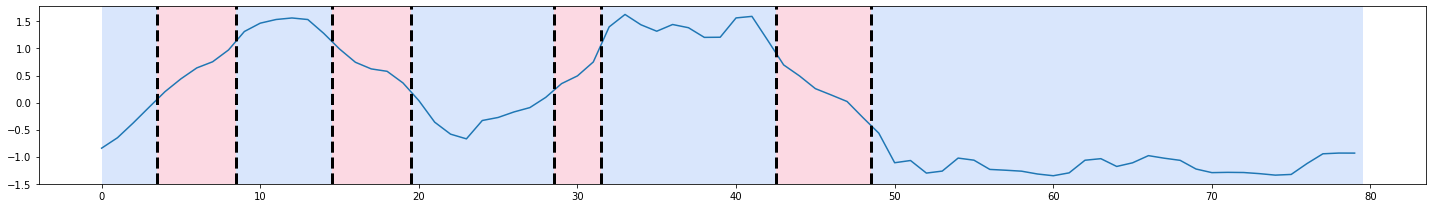

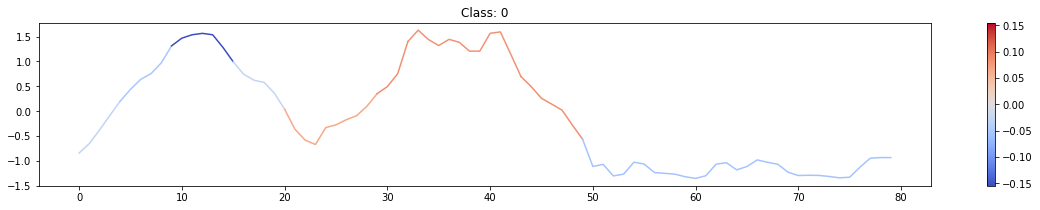

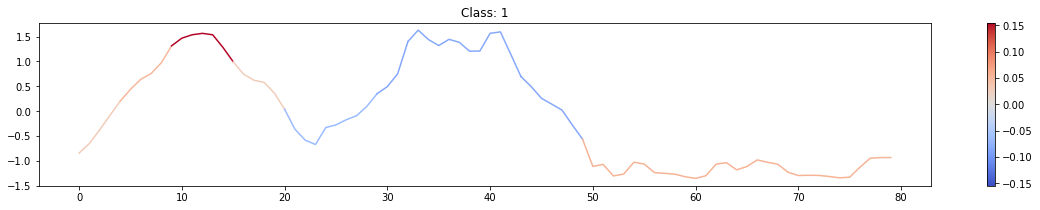

rule


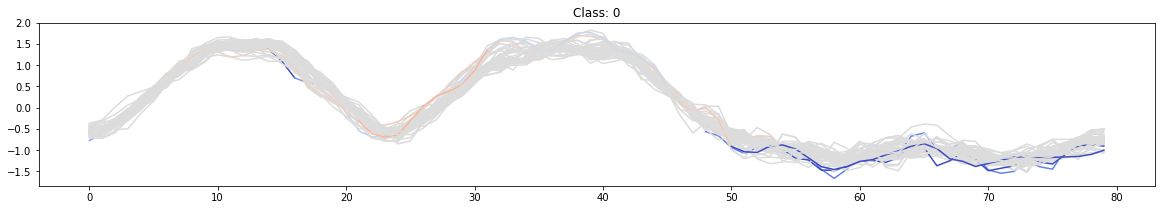

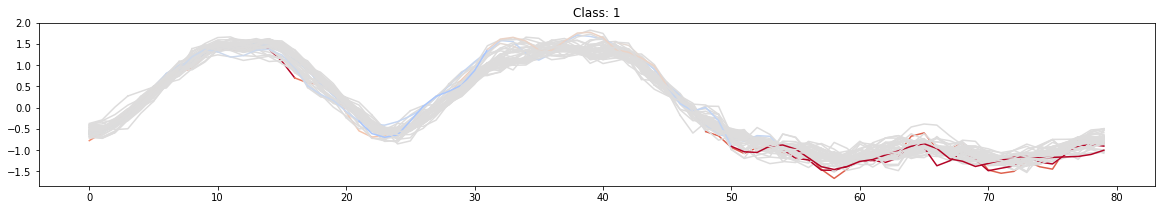

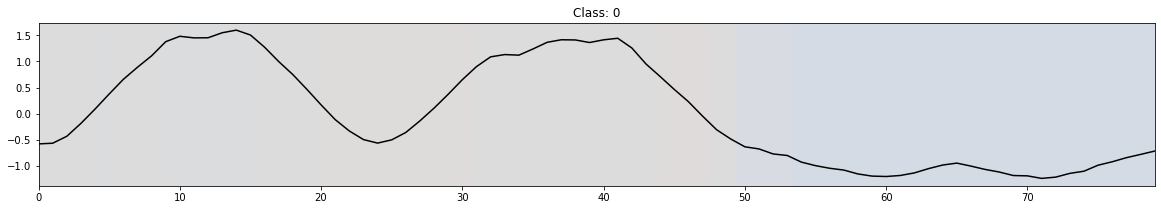

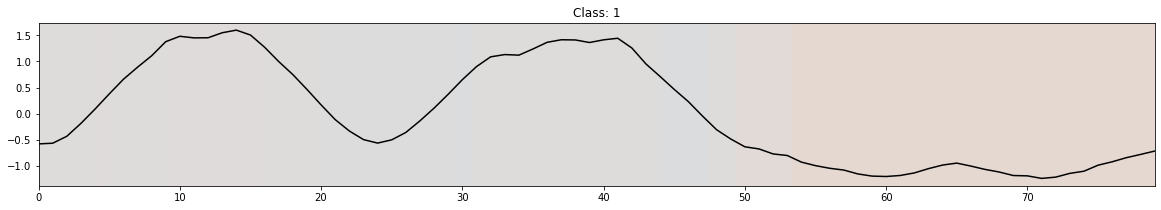

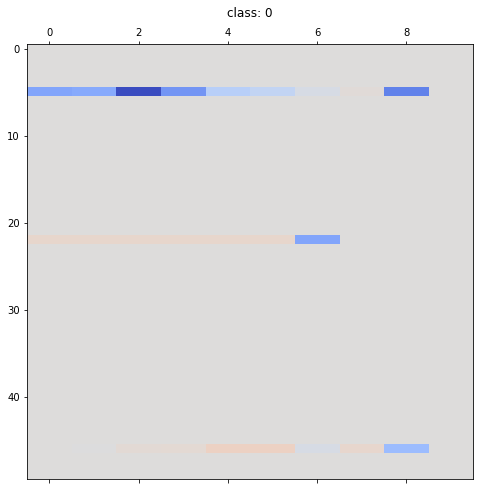

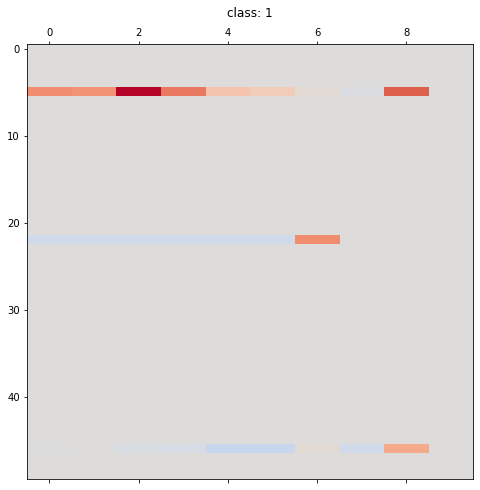

crule0


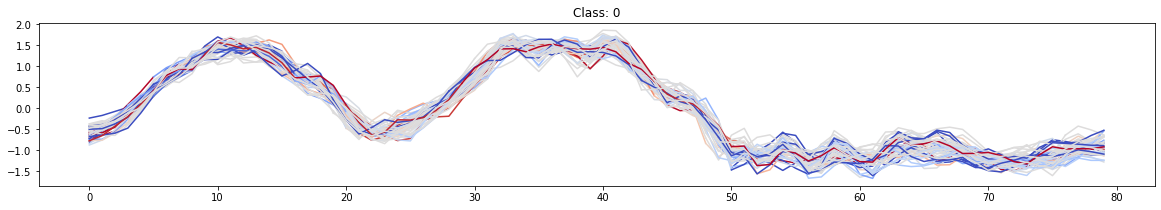

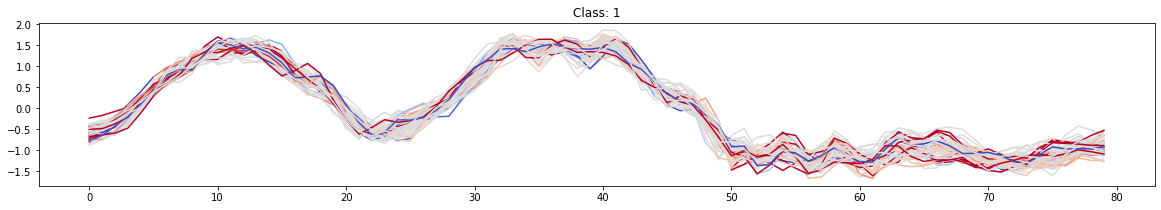

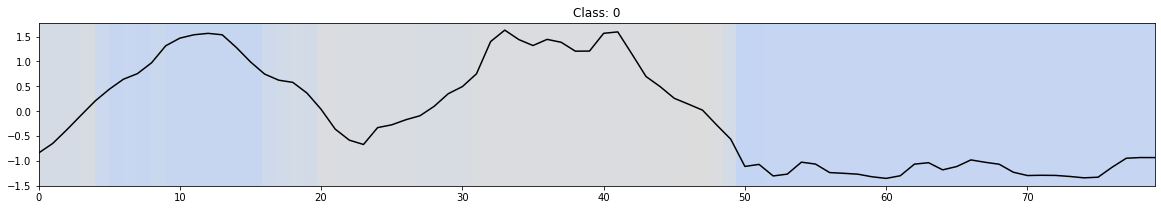

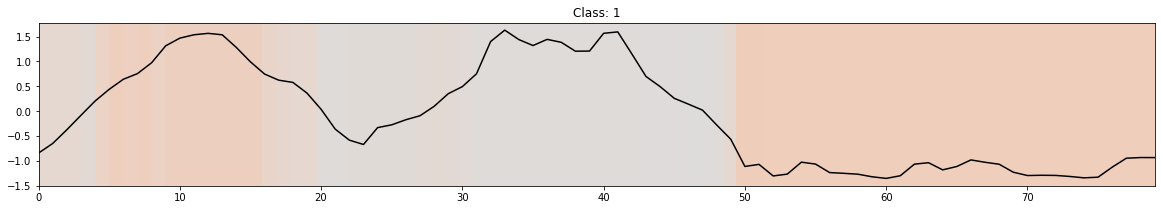

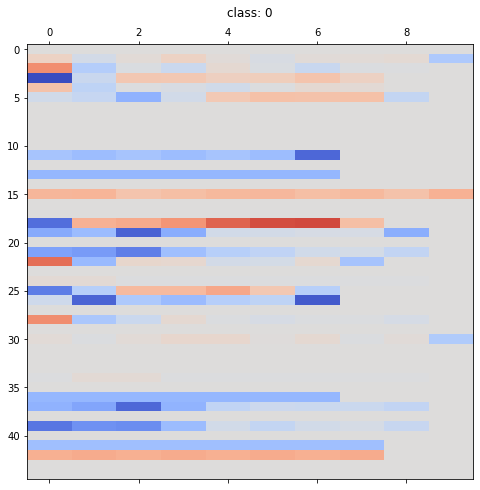

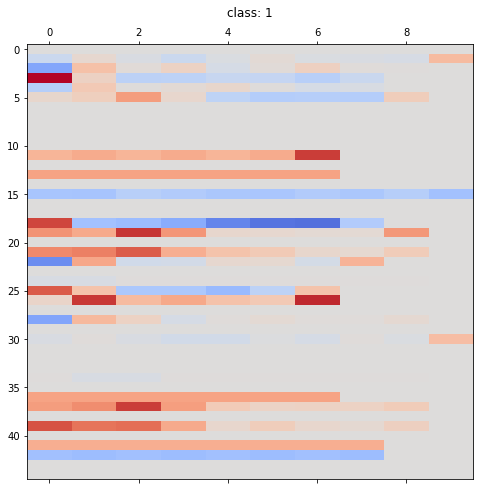

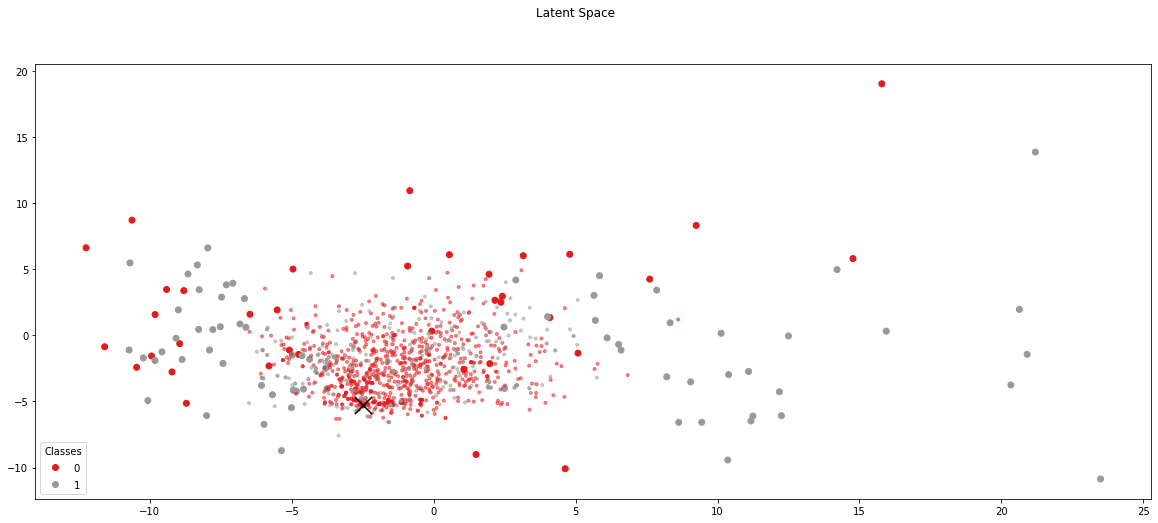

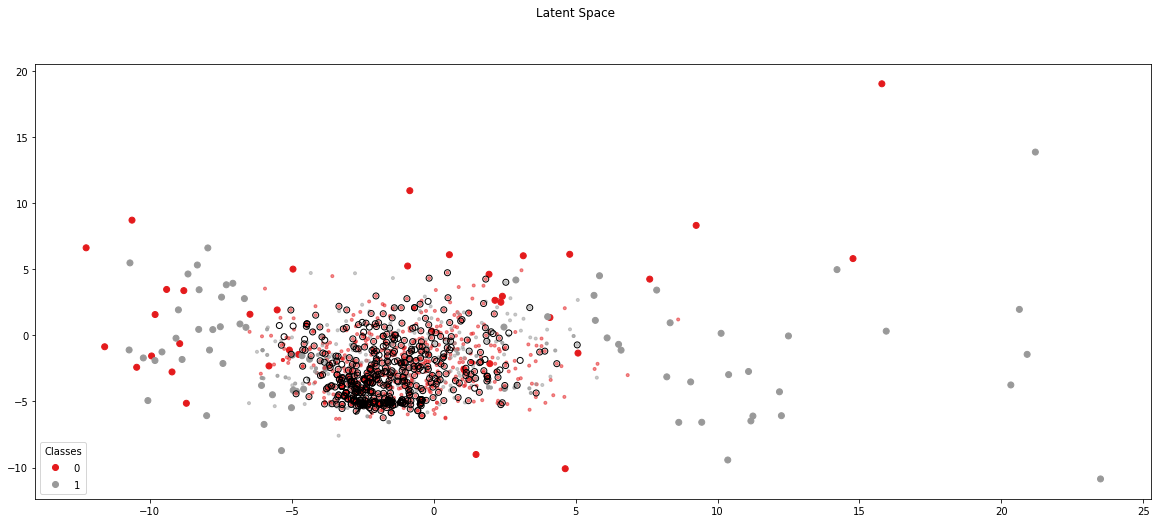

In [59]:
params = {"nsamples":1000, 
          "background":"linear_consecutive", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "multishap_n":50,
          "shap_by_class" : False,
          "max_iter":50}
agnostic.plot_explanation( 
                         rules = True, 
                         heatmap = False, 
                         shap_explanation = True, 
                         shapelet_explanation = False,
                         latent_space = True,
                         multi_shap_explanation = True,
                         figsize = (20,3),
                         VAE_2d = False,
                         **params
                         )